In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('merged.csv', index_col=0)

In [3]:
data.shape

(269560, 27)

In [4]:
print('Dataset starts on', data['ACTIVITY_TIMESTAMP_START'].min())
print('Dataset ends on', data['ACTIVITY_TIMESTAMP_START'].max())

Dataset starts on 2017-03-15T18:03:01Z
Dataset ends on 2017-09-30T23:59:33Z


In [11]:
sub = data.sort_values(['MEMBER_ID','ACTIVITY_TIMESTAMP_START']).copy()
sub['START_DAY'] = pd.to_datetime(sub['ACTIVITY_TIMESTAMP_START']).dt.date
sub['COMPLETION_RATE'] = sub['NUMBER_OF_ROUNDS_COMPLETED'] / sub['NUMBER_OF_ROUNDS_STARTED']
sub['PASS_RATE'] = sub['NUMBER_OF_PASSED_ROUNDS'] / sub['NUMBER_OF_ROUNDS_COMPLETED']
sub[['COMPLETION_RATE','PASS_RATE']] = sub[['COMPLETION_RATE','PASS_RATE']].fillna(0)
sub['IDLE%'] = 1 - sub['ACTIVITY_DURATION']/sub['TOTAL_TIME_PLAYED_IN_ACTIVITY']
sub.head()

,MEMBER_ID,ACTIVITY_ID,ACTIVITY_PLAY_ID,ACTIVITY_TIMESTAMP_START,ACTIVITY_TIMESTAMP_END,ACTIVITY_DURATION,TOTAL_TIME_PLAYED_IN_ACTIVITY,SCORE,ADAPTIVE_SCORE,NUMBER_OF_PASSED_ROUNDS,...,GAMETYPE_ID,ACTIVITY_RANGE,SERIES_ID,MASTER_ACCOUNT_MEMBER_ID,ACCOUNT_TYPE,BIRTHMONTH_Z_SCORE,START_DAY,COMPLETION_RATE,PASS_RATE,IDLE%
84849,00061a613eab2b162e0e25fb59870260ec07cd06,25497,3.184270e+11,2017-07-20T11:44:23Z,2017-07-20T11:44:53Z,30.0,30.0,NaN,0.0,0,...,2,6_10,10,363c3ea48f14e05687e7cedfb5888e9fc2eb0701,1.0,0.418837,2017-07-20,0.0,0.000000,0.000000
83579,00061a613eab2b162e0e25fb59870260ec07cd06,25508,3.184580e+11,2017-07-20T17:01:17Z,2017-07-20T17:02:01Z,44.0,44.0,NaN,6.0,6,...,3,1_5,11,363c3ea48f14e05687e7cedfb5888e9fc2eb0701,1.0,0.418837,2017-07-20,1.0,1.000000,0.000000
83962,00061a613eab2b162e0e25fb59870260ec07cd06,26619,3.184600e+11,2017-07-20T17:19:47Z,2017-07-20T17:23:20Z,213.0,213.0,NaN,2.0,2,...,4,6_10,401,363c3ea48f14e05687e7cedfb5888e9fc2eb0701,1.0,0.418837,2017-07-20,1.0,0.333333,0.000000
84056,00061a613eab2b162e0e25fb59870260ec07cd06,25497,3.184610e+11,2017-07-20T17:24:17Z,2017-07-20T22:40:43Z,162.0,18986.0,NaN,4.0,4,...,2,6_10,10,363c3ea48f14e05687e7cedfb5888e9fc2eb0701,1.0,0.418837,2017-07-20,1.0,0.666667,0.991467
83955,00061a613eab2b162e0e25fb59870260ec07cd06,25496,3.185040e+11,2017-07-20T22:43:48Z,2017-07-20T22:47:05Z,197.0,197.0,NaN,6.0,6,...,2,1_5,9,363c3ea48f14e05687e7cedfb5888e9fc2eb0701,1.0,0.418837,2017-07-20,1.0,1.000000,0.000000


In [9]:
life_summary = pd.DataFrame(sub.groupby('MEMBER_ID').first()['ACTIVITY_TIMESTAMP_START'].reset_index(name='FIRST'))
life_summary = life_summary.merge(pd.DataFrame(sub.groupby('MEMBER_ID').last()\
                                 ['ACTIVITY_TIMESTAMP_START'].reset_index(name='LAST')))
life_summary['FIRST'] = pd.to_datetime(life_summary['FIRST']).dt.date
life_summary['LAST'] = pd.to_datetime(life_summary['LAST']).dt.date
life_summary['Duration (days)'] = life_summary['LAST'] - life_summary['FIRST']
life_summary['Duration (days)'] = life_summary['Duration (days)'].dt.days+1
life_summary.head()

,MEMBER_ID,FIRST,LAST,Duration (days)
0,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,2017-07-22,3
1,0012b722266d475b27e4e5e3946cb3d28305f7df,2017-07-25,2017-07-25,1
2,0022e0f85f915460168cb98ab552f60cec91450d,2017-05-16,2017-05-16,1
3,00236e6718e23a61a6ae7c7e7bb3244dc4dcb101,2017-07-02,2017-07-02,1
4,002576a985c4614e1e7d918d4985b331d3093d34,2017-04-28,2017-07-29,93


In [12]:
history = sub.groupby(['MEMBER_ID','START_DAY']).count()['ACTIVITY_DURATION'].reset_index(name='#_SESSIONS')
history['TIME_BTW_SS'] = history.groupby('MEMBER_ID')['START_DAY'].transform(lambda x: x.diff())
history.loc[history['TIME_BTW_SS'].notnull(),'TIME_BTW_SS'] = (history[history['TIME_BTW_SS'].notnull()]['TIME_BTW_SS'].\
                                              astype('timedelta64[D]').dt.days)
history['TIME_BTW_SS'] = history['TIME_BTW_SS'].fillna(0)
history['DAY'] = history.groupby('MEMBER_ID')['TIME_BTW_SS'].transform(lambda x: x.cumsum())+1
history['LIFETIME'] = history.groupby('MEMBER_ID')['DAY'].transform(lambda x: x.max())
history['DAY_TO_QUIT'] = history['DAY']- history['LIFETIME']
history.head()

,MEMBER_ID,START_DAY,#_SESSIONS,TIME_BTW_SS,DAY,LIFETIME,DAY_TO_QUIT
0,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,8,0,1,3,-2
1,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-22,2,2,3,3,0
2,0012b722266d475b27e4e5e3946cb3d28305f7df,2017-07-25,4,0,1,1,0
3,0022e0f85f915460168cb98ab552f60cec91450d,2017-05-16,4,0,1,1,0
4,00236e6718e23a61a6ae7c7e7bb3244dc4dcb101,2017-07-02,19,0,1,1,0


In [13]:
sub['START_DAY'] = pd.to_datetime(sub['START_DAY'])
cols = ['MEMBER_ID', 'START_DAY', 'ACTIVITY_DURATION', 'IDLE%',
        'NUMBER_OF_ROUNDS_STARTED', 'COMPLETION_RATE', 'PASS_RATE', 'NUMBER_OF_FAILED_ROUNDS',
        'NUMBER_OF_SUBMITS', 'POINTS_EARNED', 'STARS_EARNED', 'ACTIVITYPLAY_OUTCOME', 
        'ACTIVITY_DIFFICULTY_ID', 'GAMETYPE_ID', 
        'ACCOUNT_TYPE', 'BIRTHMONTH_Z_SCORE']
short = sub[cols].copy()
short.rename(columns={'START_DAY':'ACTIVE_DATE'},inplace=True)
short.loc[short['IDLE%']<0,'IDLE%'] = 0
short.head()

,MEMBER_ID,ACTIVE_DATE,ACTIVITY_DURATION,IDLE%,NUMBER_OF_ROUNDS_STARTED,COMPLETION_RATE,PASS_RATE,NUMBER_OF_FAILED_ROUNDS,NUMBER_OF_SUBMITS,POINTS_EARNED,STARS_EARNED,ACTIVITYPLAY_OUTCOME,ACTIVITY_DIFFICULTY_ID,GAMETYPE_ID,ACCOUNT_TYPE,BIRTHMONTH_Z_SCORE
84849,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,30.0,0.000000,1,0.0,0.000000,0,0,0,0,cancel,1,2,1.0,0.418837
83579,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,44.0,0.000000,6,1.0,1.000000,0,5,0,0,succeed,1,3,1.0,0.418837
83962,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,213.0,0.000000,6,1.0,0.333333,4,5,4,0,succeed,1,4,1.0,0.418837
84056,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,162.0,0.991467,6,1.0,0.666667,2,5,4,0,succeed,1,2,1.0,0.418837
83955,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,197.0,0.000000,6,1.0,1.000000,0,5,4,0,succeed,1,2,1.0,0.418837


In [15]:
history.rename(columns={'START_DAY':'ACTIVE_DATE'}, inplace = True)
history['ACTIVE_DATE'] = pd.to_datetime(history['ACTIVE_DATE'])
mg = short.merge(history[['MEMBER_ID','ACTIVE_DATE','#_SESSIONS','TIME_BTW_SS']], how='left')
mg.head()

,MEMBER_ID,ACTIVE_DATE,ACTIVITY_DURATION,IDLE%,NUMBER_OF_ROUNDS_STARTED,COMPLETION_RATE,PASS_RATE,NUMBER_OF_FAILED_ROUNDS,NUMBER_OF_SUBMITS,POINTS_EARNED,STARS_EARNED,ACTIVITYPLAY_OUTCOME,ACTIVITY_DIFFICULTY_ID,GAMETYPE_ID,ACCOUNT_TYPE,BIRTHMONTH_Z_SCORE,#_SESSIONS,TIME_BTW_SS
0,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,30.0,0.000000,1,0.0,0.000000,0,0,0,0,cancel,1,2,1.0,0.418837,8,0
1,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,44.0,0.000000,6,1.0,1.000000,0,5,0,0,succeed,1,3,1.0,0.418837,8,0
2,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,213.0,0.000000,6,1.0,0.333333,4,5,4,0,succeed,1,4,1.0,0.418837,8,0
3,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,162.0,0.991467,6,1.0,0.666667,2,5,4,0,succeed,1,2,1.0,0.418837,8,0
4,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,197.0,0.000000,6,1.0,1.000000,0,5,4,0,succeed,1,2,1.0,0.418837,8,0


In [16]:
mg.shape

(269560, 18)

In [17]:
mg['MEMBER_ID'].nunique()

12696

In [18]:
df = pd.DataFrame()
count = 0
for member in mg['MEMBER_ID'].unique():
    hist = mg[mg['MEMBER_ID']==member]
    #print(hist)
    if (hist[hist['ACTIVE_DATE']<pd.to_datetime('2017-09-01')]['ACTIVE_DATE'].nunique() >= 3) \
    and (hist['ACTIVE_DATE'].min()>pd.to_datetime('2017-04-13')):
        if hist[hist['TIME_BTW_SS']>30].shape[0] != 0:
            last_date_before = hist[hist['TIME_BTW_SS']>30]['ACTIVE_DATE'].min()
            if hist[hist['ACTIVE_DATE']<last_date_before]['ACTIVE_DATE'].nunique() >= 3:
                temp = hist[hist['ACTIVE_DATE']<last_date_before].copy()
                temp.loc[:,'CHURN'] = 1
                temp.loc[:,'LAST_RECORD'] = temp.loc[:,'ACTIVE_DATE'].max()+pd.DateOffset(30)
                df = df.append(temp, ignore_index=True)
        else:
            if hist['ACTIVE_DATE'].max()<pd.to_datetime('2017-09-01'):
                temp = hist.copy()
                temp.loc[:,'CHURN'] = 1
                temp.loc[:,'LAST_RECORD'] = temp.loc[:,'ACTIVE_DATE'].max()+pd.DateOffset(30)
            else:
                temp = hist[hist['ACTIVE_DATE']<pd.to_datetime('2017-09-01')].copy()
                temp.loc[:,'CHURN'] = 0
                temp.loc[:,'LAST_RECORD'] = pd.to_datetime('2017-08-31')
            df = df.append(temp, ignore_index=True)
    count += 1
    if count % 1000 == 0:
        print(count, 'member processed')
        print(df.shape[0], 'rows added')

1000 member processed
11895 rows added
2000 member processed
25439 rows added
3000 member processed
37221 rows added
4000 member processed
49378 rows added
5000 member processed
61816 rows added
6000 member processed
74821 rows added
7000 member processed
89557 rows added
8000 member processed
102187 rows added
9000 member processed
114976 rows added
10000 member processed
126883 rows added
11000 member processed
139107 rows added
12000 member processed
152607 rows added


In [19]:
df.shape

(161370, 20)

In [20]:
df.groupby('CHURN').nunique()['MEMBER_ID']

CHURN
0     970
1    3601
Name: MEMBER_ID, dtype: int64

In [21]:
df_backup = df.copy()

In [22]:
df['OUTCOME_SUCCESS'] = df['ACTIVITYPLAY_OUTCOME'].map({'succeed':1, 'cancel':0})

In [173]:
member = '002576a985c4614e1e7d918d4985b331d3093d34'
hist = df[df['MEMBER_ID']==member]
last_day = hist['LAST_RECORD'].reset_index().loc[0,'LAST_RECORD']
mean_cols = ['#_SESSIONS', 'ACTIVITY_DURATION','IDLE%','NUMBER_OF_ROUNDS_STARTED','COMPLETION_RATE','PASS_RATE',
        'NUMBER_OF_FAILED_ROUNDS', 'NUMBER_OF_SUBMITS','POINTS_EARNED','STARS_EARNED','OUTCOME_SUCCESS']
temp = hist.groupby('ACTIVE_DATE').mean()[mean_cols].reset_index()
temp['MEMBER_ID'] = member
temp = temp.merge(hist[['ACTIVE_DATE','ACTIVITY_DIFFICULTY_ID','GAMETYPE_ID']].\
                  groupby('ACTIVE_DATE').agg(lambda x:x.value_counts().index[0]).reset_index())
concentration = hist[['ACTIVE_DATE','ACTIVITY_DIFFICULTY_ID','GAMETYPE_ID']].\
                  groupby('ACTIVE_DATE').agg(lambda x:x.value_counts().reset_index().iloc[0,1]).reset_index()
concentration.columns = ['ACTIVE_DATE', 'MOST_DIFFICULTY%','MOST_GAMETYPE%']
temp = temp.merge(concentration)
temp['MOST_DIFFICULTY%'] = temp['MOST_DIFFICULTY%']/temp['#_SESSIONS']
temp['MOST_GAMETYPE%'] = temp['MOST_GAMETYPE%']/temp['#_SESSIONS']
temp['DATE'] = temp['ACTIVE_DATE']
temp = temp[['MEMBER_ID', 'DATE', 'ACTIVE_DATE', '#_SESSIONS', 
            'ACTIVITY_DURATION', 'IDLE%', 'NUMBER_OF_ROUNDS_STARTED', 'COMPLETION_RATE', 
            'PASS_RATE', 'NUMBER_OF_FAILED_ROUNDS', 'NUMBER_OF_SUBMITS', 'POINTS_EARNED',
            'STARS_EARNED', 'OUTCOME_SUCCESS', 'ACTIVITY_DIFFICULTY_ID', 
            'GAMETYPE_ID', 'MOST_DIFFICULTY%','MOST_GAMETYPE%']]
temp.columns = ['MEMBER_ID', 'DATE', 'LAST_ACTIVE_DATE', 'LAST_#_SESSIONS', 
                'LAST_AVG_SESSION_LENGTH', 'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED', 
                'LAST_AVG_COMPLETION_RATE', 'LAST_AVG_PASS_RATE', 'LAST_AVG_FAILED_ROUNDS', 
                'LAST_AVG_SUBMITS', 'LAST_AVG_POINTS', 'LAST_AVG_STARS', 'LAST_AVG_SUCCESS%', 
                'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE', 'LAST_MOST_DIFFICULTY%','LAST_MOST_GAMETYPE%']
temp['ACC_ACTIVE_DAYS'] = temp.index + 1
temp['INTERVAL'] = temp['LAST_ACTIVE_DATE'].transform(lambda x: x.diff())
temp.loc[temp['INTERVAL'].notnull(), 'INTERVAL'] = temp.loc[temp['INTERVAL'].notnull(), 'INTERVAL'].dt.days
temp['INTERVAL'] = temp['INTERVAL'].fillna(0).astype(int)
temp['AVG_INTERVAL_BTW_LAST3'] = temp['INTERVAL'].rolling(2).mean() - 1
temp['INTERVAL_CHG_LAST3'] = temp['INTERVAL'].transform(lambda x: x.diff())
temp['OVR_AVG_#_SESSIONS'] = temp['LAST_#_SESSIONS'].expanding(3).mean()
temp['OVR_MOST_DIFFICULTY%'] = temp['LAST_MOST_DIFFICULTY%'].expanding(3).mean()
temp['OVR_MOST_GAMETYPE%'] = temp['LAST_MOST_GAMETYPE%'].expanding(3).mean()

roll = hist[['ACTIVITY_DURATION','COMPLETION_RATE', 'PASS_RATE',
               'POINTS_EARNED', 'STARS_EARNED']].expanding().mean()
roll['ACTIVE_DATE'] = hist['ACTIVE_DATE']
add = roll.groupby('ACTIVE_DATE').last().reset_index()
add.columns = ['LAST_ACTIVE_DATE','OVR_AVG_SESSION_LENGTH', 'OVR_AVG_COMPLETION_RATE',
               'OVR_AVG_PASS_RATE', 'OVR_AVG_POINTS', 'OVR_AVG_STARS']
temp = temp.merge(add)
temp['CHG_AVG_#_SESSIONS'] = temp['LAST_#_SESSIONS'] - temp['OVR_AVG_#_SESSIONS']
temp['CHG_MOST_DIFFICULTY%'] = temp['LAST_MOST_DIFFICULTY%'] - temp['OVR_MOST_DIFFICULTY%']
temp['CHG_MOST_GAMETYPE%'] = temp['LAST_MOST_GAMETYPE%'] - temp['OVR_MOST_GAMETYPE%']
temp['CHG_AVG_SESSION_LENGTH'] = temp['LAST_AVG_SESSION_LENGTH'] - temp['OVR_AVG_SESSION_LENGTH']
temp['CHG_AVG_COMPLETION_RATE'] = temp['LAST_AVG_COMPLETION_RATE'] - temp['OVR_AVG_COMPLETION_RATE']
temp['CHG_AVG_PASS_RATE'] = temp['LAST_AVG_PASS_RATE'] - temp['OVR_AVG_PASS_RATE']
temp['CHG_AVG_POINTS'] = temp['LAST_AVG_POINTS'] - temp['OVR_AVG_POINTS']
temp['CHG_AVG_STARS'] = temp['LAST_AVG_STARS'] - temp['OVR_AVG_STARS']
temp = temp.drop(0, axis=0)
temp['OVR_AVG_INTERVAL'] = temp['INTERVAL'].expanding(2).mean() - 1
temp['CHG_AVG_INTERVAL'] = temp['AVG_INTERVAL_BTW_LAST3'] - temp['OVR_AVG_INTERVAL']
temp = temp.drop(1, axis=0)

active_days = temp['LAST_ACTIVE_DATE']
for i in range((last_day - temp['DATE'].min()).components.days):
    date = temp['DATE'].min() + pd.DateOffset(i+1)
    if date <= last_day:
        if np.datetime64(date) not in pd.to_datetime(active_days).values:
            last_active = temp[temp['LAST_ACTIVE_DATE'] < date]['LAST_ACTIVE_DATE'].max()
            copy_record = temp[temp['DATE']==last_active].copy()
            copy_record['DATE'] = date            
            temp = temp.append(copy_record, ignore_index=True)
temp = temp.sort_values('DATE')

temp['DAY_SINCE_LAST_ACTIVE'] = temp['DATE'] - temp['LAST_ACTIVE_DATE']
temp['DAY_SINCE_LAST_ACTIVE'] = temp['DAY_SINCE_LAST_ACTIVE'].dt.days

last_active_day = temp['LAST_ACTIVE_DATE'].max()
if hist['CHURN'].min() == 0:
    temp['CHURN'] = 0
else:
    temp.loc[temp['DATE']<last_active_day,'CHURN'] = 0
    temp.loc[temp['DATE']>=last_active_day,'CHURN'] = 1

temp = temp[['MEMBER_ID', 'DATE', 'LAST_ACTIVE_DATE', 'CHURN',
            'ACC_ACTIVE_DAYS', 'INTERVAL', 
            'DAY_SINCE_LAST_ACTIVE', 'AVG_INTERVAL_BTW_LAST3', 'INTERVAL_CHG_LAST3', 
            'OVR_AVG_INTERVAL', 'CHG_AVG_INTERVAL',
             # comparisons
            'LAST_#_SESSIONS', 'OVR_AVG_#_SESSIONS', 'CHG_AVG_#_SESSIONS', 
            'LAST_AVG_SESSION_LENGTH', 'OVR_AVG_SESSION_LENGTH','CHG_AVG_SESSION_LENGTH',
            'LAST_AVG_COMPLETION_RATE', 'OVR_AVG_COMPLETION_RATE', 'CHG_AVG_COMPLETION_RATE', 
            'LAST_AVG_PASS_RATE', 'OVR_AVG_PASS_RATE', 'CHG_AVG_PASS_RATE', 
            'LAST_AVG_STARS', 'OVR_AVG_STARS', 'CHG_AVG_STARS',
            'LAST_AVG_POINTS', 'OVR_AVG_POINTS', 'CHG_AVG_POINTS',
            'LAST_MOST_DIFFICULTY%', 'OVR_MOST_DIFFICULTY%', 'CHG_MOST_DIFFICULTY%',
            'LAST_MOST_GAMETYPE%', 'OVR_MOST_GAMETYPE%', 'CHG_MOST_GAMETYPE%',  
            # only last session
            'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED', 
            'LAST_AVG_FAILED_ROUNDS', 'LAST_AVG_SUBMITS', 'LAST_AVG_SUCCESS%', 
            'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE']]
temp

,MEMBER_ID,DATE,LAST_ACTIVE_DATE,CHURN,ACC_ACTIVE_DAYS,INTERVAL,DAY_SINCE_LAST_ACTIVE,AVG_INTERVAL_BTW_LAST3,INTERVAL_CHG_LAST3,OVR_AVG_INTERVAL,...,LAST_MOST_GAMETYPE%,OVR_MOST_GAMETYPE%,CHG_MOST_GAMETYPE%,LAST_AVG_IDLE%,LAST_AVG_ROUNDS_STARTED,LAST_AVG_FAILED_ROUNDS,LAST_AVG_SUBMITS,LAST_AVG_SUCCESS%,LAST_MOST_DIFFICULTY,LAST_MOST_GAMETYPE
0,002576a985c4614e1e7d918d4985b331d3093d34,2017-04-30,2017-04-30,0.0,3,1,0,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
7,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-01,2017-04-30,0.0,3,1,1,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
8,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-02,2017-04-30,0.0,3,1,2,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
9,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-03,2017-04-30,0.0,3,1,3,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
10,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-04,2017-04-30,0.0,3,1,4,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
11,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-05,2017-04-30,0.0,3,1,5,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
12,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-06,2017-04-30,0.0,3,1,6,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
13,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-07,2017-04-30,0.0,3,1,7,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
14,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-08,2017-04-30,0.0,3,1,8,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3
15,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-09,2017-04-30,0.0,3,1,9,0.0,0.0,0.000000,...,0.333333,0.644444,-0.311111,0.000000,1.000000,0.000000,0.000000,0.000000,2,3


In [164]:
len(temp.columns)

42

In [174]:
mean_cols = ['#_SESSIONS', 'ACTIVITY_DURATION','IDLE%','NUMBER_OF_ROUNDS_STARTED','COMPLETION_RATE','PASS_RATE',
            'NUMBER_OF_FAILED_ROUNDS', 'NUMBER_OF_SUBMITS','POINTS_EARNED','STARS_EARNED','OUTCOME_SUCCESS']

records = pd.DataFrame()
count = 0

for member in df['MEMBER_ID'].unique():
    hist = df[df['MEMBER_ID']==member]
    last_day = hist['LAST_RECORD'].reset_index().loc[0,'LAST_RECORD']
    temp = hist.groupby('ACTIVE_DATE').mean()[mean_cols].reset_index()
    temp['MEMBER_ID'] = member
    temp = temp.merge(hist[['ACTIVE_DATE','ACTIVITY_DIFFICULTY_ID','GAMETYPE_ID']].\
                      groupby('ACTIVE_DATE').agg(lambda x:x.value_counts().index[0]).reset_index())
    concentration = hist[['ACTIVE_DATE','ACTIVITY_DIFFICULTY_ID','GAMETYPE_ID']].\
                      groupby('ACTIVE_DATE').agg(lambda x:x.value_counts().reset_index().iloc[0,1]).reset_index()
    concentration.columns = ['ACTIVE_DATE', 'MOST_DIFFICULTY%','MOST_GAMETYPE%']
    temp = temp.merge(concentration)
    temp['MOST_DIFFICULTY%'] = temp['MOST_DIFFICULTY%']/temp['#_SESSIONS']
    temp['MOST_GAMETYPE%'] = temp['MOST_GAMETYPE%']/temp['#_SESSIONS']
    temp['DATE'] = temp['ACTIVE_DATE']
    
    temp = temp[['MEMBER_ID', 'DATE', 'ACTIVE_DATE', '#_SESSIONS', 
                'ACTIVITY_DURATION', 'IDLE%', 'NUMBER_OF_ROUNDS_STARTED', 'COMPLETION_RATE', 
                'PASS_RATE', 'NUMBER_OF_FAILED_ROUNDS', 'NUMBER_OF_SUBMITS', 'POINTS_EARNED',
                'STARS_EARNED', 'OUTCOME_SUCCESS', 'ACTIVITY_DIFFICULTY_ID', 
                'GAMETYPE_ID', 'MOST_DIFFICULTY%','MOST_GAMETYPE%']]
    temp.columns = ['MEMBER_ID', 'DATE', 'LAST_ACTIVE_DATE', 'LAST_#_SESSIONS', 
                    'LAST_AVG_SESSION_LENGTH', 'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED', 
                    'LAST_AVG_COMPLETION_RATE', 'LAST_AVG_PASS_RATE', 'LAST_AVG_FAILED_ROUNDS', 
                    'LAST_AVG_SUBMITS', 'LAST_AVG_POINTS', 'LAST_AVG_STARS', 'LAST_AVG_SUCCESS%', 
                    'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE', 'LAST_MOST_DIFFICULTY%','LAST_MOST_GAMETYPE%']
    
    temp['ACC_ACTIVE_DAYS'] = temp.index + 1
    temp['INTERVAL'] = temp['LAST_ACTIVE_DATE'].transform(lambda x: x.diff())
    temp.loc[temp['INTERVAL'].notnull(), 'INTERVAL'] = temp.loc[temp['INTERVAL'].notnull(), 'INTERVAL'].dt.days
    temp['INTERVAL'] = temp['INTERVAL'].fillna(0).astype(int)
    temp['AVG_INTERVAL_BTW_LAST3'] = temp['INTERVAL'].rolling(2).mean() - 1
    temp['INTERVAL_CHG_LAST3'] = temp['INTERVAL'].transform(lambda x: x.diff())
    temp['OVR_AVG_#_SESSIONS'] = temp['LAST_#_SESSIONS'].expanding(3).mean()
    temp['OVR_MOST_DIFFICULTY%'] = temp['LAST_MOST_DIFFICULTY%'].expanding(3).mean()
    temp['OVR_MOST_GAMETYPE%'] = temp['LAST_MOST_GAMETYPE%'].expanding(3).mean()

    roll = hist[['ACTIVITY_DURATION','COMPLETION_RATE', 'PASS_RATE',
                   'POINTS_EARNED', 'STARS_EARNED']].expanding().mean()
    roll['ACTIVE_DATE'] = hist['ACTIVE_DATE']
    add = roll.groupby('ACTIVE_DATE').last().reset_index()
    add.columns = ['LAST_ACTIVE_DATE','OVR_AVG_SESSION_LENGTH', 'OVR_AVG_COMPLETION_RATE',
                   'OVR_AVG_PASS_RATE', 'OVR_AVG_POINTS', 'OVR_AVG_STARS']
    temp = temp.merge(add)
    temp['CHG_AVG_#_SESSIONS'] = temp['LAST_#_SESSIONS'] - temp['OVR_AVG_#_SESSIONS']
    temp['CHG_MOST_DIFFICULTY%'] = temp['LAST_MOST_DIFFICULTY%'] - temp['OVR_MOST_DIFFICULTY%']
    temp['CHG_MOST_GAMETYPE%'] = temp['LAST_MOST_GAMETYPE%'] - temp['OVR_MOST_GAMETYPE%']
    temp['CHG_AVG_SESSION_LENGTH'] = temp['LAST_AVG_SESSION_LENGTH'] - temp['OVR_AVG_SESSION_LENGTH']
    temp['CHG_AVG_COMPLETION_RATE'] = temp['LAST_AVG_COMPLETION_RATE'] - temp['OVR_AVG_COMPLETION_RATE']
    temp['CHG_AVG_PASS_RATE'] = temp['LAST_AVG_PASS_RATE'] - temp['OVR_AVG_PASS_RATE']
    temp['CHG_AVG_POINTS'] = temp['LAST_AVG_POINTS'] - temp['OVR_AVG_POINTS']
    temp['CHG_AVG_STARS'] = temp['LAST_AVG_STARS'] - temp['OVR_AVG_STARS']
    temp = temp.drop(0, axis=0)
    temp['OVR_AVG_INTERVAL'] = temp['INTERVAL'].expanding(2).mean() - 1
    temp['CHG_AVG_INTERVAL'] = temp['AVG_INTERVAL_BTW_LAST3'] - temp['OVR_AVG_INTERVAL']
    temp = temp.drop(1, axis=0)

    active_days = temp['LAST_ACTIVE_DATE']
    for i in range((last_day - temp['DATE'].min()).components.days):
        date = temp['DATE'].min() + pd.DateOffset(i+1)
        if date <= last_day:
            if np.datetime64(date) not in pd.to_datetime(active_days).values:
                last_active = temp[temp['LAST_ACTIVE_DATE'] < date]['LAST_ACTIVE_DATE'].max()
                copy_record = temp[temp['DATE']==last_active].copy()
                copy_record['DATE'] = date            
                temp = temp.append(copy_record, ignore_index=True)
    temp = temp.sort_values('DATE')

    temp['DAY_SINCE_LAST_ACTIVE'] = temp['DATE'] - temp['LAST_ACTIVE_DATE']
    temp['DAY_SINCE_LAST_ACTIVE'] = temp['DAY_SINCE_LAST_ACTIVE'].dt.days
    
    last_active_day = temp['LAST_ACTIVE_DATE'].max()
    if hist['CHURN'].min() == 0:
        temp['CHURN'] = 0
    else:
        temp.loc[temp['DATE']<last_active_day,'CHURN'] = 0
        temp.loc[temp['DATE']>=last_active_day,'CHURN'] = 1

    temp = temp[['MEMBER_ID', 'DATE', 'LAST_ACTIVE_DATE', 'CHURN',
                'ACC_ACTIVE_DAYS', 'INTERVAL', 
                'DAY_SINCE_LAST_ACTIVE', 'AVG_INTERVAL_BTW_LAST3', 'INTERVAL_CHG_LAST3', 
                'OVR_AVG_INTERVAL', 'CHG_AVG_INTERVAL',
                 # comparisons
                'LAST_#_SESSIONS', 'OVR_AVG_#_SESSIONS', 'CHG_AVG_#_SESSIONS', 
                'LAST_AVG_SESSION_LENGTH', 'OVR_AVG_SESSION_LENGTH','CHG_AVG_SESSION_LENGTH',
                'LAST_AVG_COMPLETION_RATE', 'OVR_AVG_COMPLETION_RATE', 'CHG_AVG_COMPLETION_RATE', 
                'LAST_AVG_PASS_RATE', 'OVR_AVG_PASS_RATE', 'CHG_AVG_PASS_RATE', 
                'LAST_AVG_STARS', 'OVR_AVG_STARS', 'CHG_AVG_STARS',
                'LAST_AVG_POINTS', 'OVR_AVG_POINTS', 'CHG_AVG_POINTS',
                'LAST_MOST_DIFFICULTY%', 'OVR_MOST_DIFFICULTY%', 'CHG_MOST_DIFFICULTY%',
                'LAST_MOST_GAMETYPE%', 'OVR_MOST_GAMETYPE%', 'CHG_MOST_GAMETYPE%',  
                # only last session
                'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED', 
                'LAST_AVG_FAILED_ROUNDS', 'LAST_AVG_SUBMITS', 'LAST_AVG_SUCCESS%', 
                'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE']]
    
    records = records.append(temp)
    
    count += 1
    if count%100 == 0:
        print(count, 'member processed')
        print(records.shape[0], 'rows added')

100 member processed
4366 rows added
200 member processed
8553 rows added
300 member processed
12842 rows added
400 member processed
17249 rows added
500 member processed
21758 rows added
600 member processed
25786 rows added
700 member processed
30262 rows added
800 member processed
34684 rows added
900 member processed
39240 rows added
1000 member processed
43921 rows added
1100 member processed
48452 rows added
1200 member processed
52854 rows added
1300 member processed
57098 rows added
1400 member processed
61267 rows added
1500 member processed
65729 rows added
1600 member processed
70084 rows added
1700 member processed
74625 rows added
1800 member processed
79043 rows added
1900 member processed
83350 rows added
2000 member processed
88280 rows added
2100 member processed
92605 rows added
2200 member processed
97238 rows added
2300 member processed
101537 rows added
2400 member processed
106209 rows added
2500 member processed
110734 rows added
2600 member processed
115046 rows

In [175]:
records.shape

(200923, 42)

In [176]:
records.head()

,MEMBER_ID,DATE,LAST_ACTIVE_DATE,CHURN,ACC_ACTIVE_DAYS,INTERVAL,DAY_SINCE_LAST_ACTIVE,AVG_INTERVAL_BTW_LAST3,INTERVAL_CHG_LAST3,OVR_AVG_INTERVAL,...,LAST_MOST_GAMETYPE%,OVR_MOST_GAMETYPE%,CHG_MOST_GAMETYPE%,LAST_AVG_IDLE%,LAST_AVG_ROUNDS_STARTED,LAST_AVG_FAILED_ROUNDS,LAST_AVG_SUBMITS,LAST_AVG_SUCCESS%,LAST_MOST_DIFFICULTY,LAST_MOST_GAMETYPE
0,002576a985c4614e1e7d918d4985b331d3093d34,2017-04-30,2017-04-30,0.0,3,1,0,0.0,0.0,0.0,...,0.333333,0.644444,-0.311111,0.0,1.0,0.0,0.0,0.0,2,3
7,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-01,2017-04-30,0.0,3,1,1,0.0,0.0,0.0,...,0.333333,0.644444,-0.311111,0.0,1.0,0.0,0.0,0.0,2,3
8,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-02,2017-04-30,0.0,3,1,2,0.0,0.0,0.0,...,0.333333,0.644444,-0.311111,0.0,1.0,0.0,0.0,0.0,2,3
9,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-03,2017-04-30,0.0,3,1,3,0.0,0.0,0.0,...,0.333333,0.644444,-0.311111,0.0,1.0,0.0,0.0,0.0,2,3
10,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-04,2017-04-30,0.0,3,1,4,0.0,0.0,0.0,...,0.333333,0.644444,-0.311111,0.0,1.0,0.0,0.0,0.0,2,3


In [181]:
records[records['DATE']==pd.to_datetime('2017-04-16')]

,MEMBER_ID,DATE,LAST_ACTIVE_DATE,CHURN,ACC_ACTIVE_DAYS,INTERVAL,DAY_SINCE_LAST_ACTIVE,AVG_INTERVAL_BTW_LAST3,INTERVAL_CHG_LAST3,OVR_AVG_INTERVAL,...,LAST_MOST_GAMETYPE%,OVR_MOST_GAMETYPE%,CHG_MOST_GAMETYPE%,LAST_AVG_IDLE%,LAST_AVG_ROUNDS_STARTED,LAST_AVG_FAILED_ROUNDS,LAST_AVG_SUBMITS,LAST_AVG_SUCCESS%,LAST_MOST_DIFFICULTY,LAST_MOST_GAMETYPE
0,cb97151024dc5f3ff5cccb07f0043289fe4983ad,2017-04-16,2017-04-16,0.0,3,1,0,0.0,0.0,0.0,...,1.0,0.84058,0.15942,0.007723,3.363636,1.0,5.0,1.0,4,2


In [185]:
record_count = records['DATE'].value_counts().reset_index()
record_count.columns = ['DATE','COUNT']
record_count = record_count.sort_values('DATE')
churn_by_date = records.groupby('DATE').mean()['CHURN'].reset_index()
record_summary = churn_by_date.merge(record_count)
record_summary.head()

,DATE,CHURN,COUNT
0,2017-04-16,0.000000,1
1,2017-04-17,0.166667,6
2,2017-04-18,0.181818,11
3,2017-04-19,0.166667,18
4,2017-04-20,0.240000,25


In [186]:
record_summary.shape

(168, 3)

In [187]:
records['DATE'].nunique()

168

<Figure size 432x288 with 0 Axes>

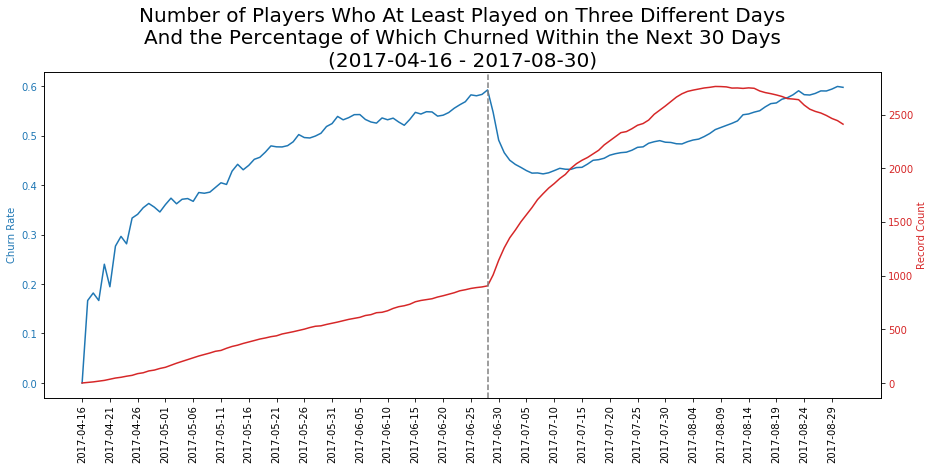

In [377]:
dff = record_summary[record_summary['DATE']<pd.to_datetime('2017-09-01')]

fig = plt.figure()
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.plot(dff['DATE'], dff['CHURN'], color='tab:blue')
ax1.set_ylabel('Churn Rate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
#plt.xticks(dff['DATE'][::5])
#ax1.set_yticks(np.arange(0,0.7,0.1))

ax2 = ax1.twinx() 
ax2.plot(dff['DATE'], dff['COUNT'], color='tab:red')
ax2.set_ylabel('Record Count', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_xticks(dff['DATE'][::5])
ax1.set_xticklabels(dff['DATE'].astype(str)[::5], rotation=90)

#plt.xticks(dff['DATE'][::5])
plt.axvline('2017-06-28', linestyle='--', color='grey')
# Number of users who at least played 3 active days soared since 2017-06-29 while churn rate dropped substantially
# Indicating major change happened on 2017-06-27, which is in line with the pattern shown in the DAU plot

plt.title('Number of Players Who At Least Played on Three Different Days\nAnd the Percentage of Which Churned Within the Next 30 Days\n(2017-04-16 - 2017-08-30)',
         fontsize=20)
plt.show()

In [227]:
record_summary[record_summary['DATE']>'2017-06-20'].head(15)

,DATE,CHURN,COUNT
66,2017-06-21,0.546554,827
67,2017-06-22,0.555291,841
68,2017-06-23,0.562282,859
69,2017-06-24,0.568470,869
70,2017-06-25,0.582293,881
71,2017-06-26,0.580427,889
72,2017-06-27,0.583240,895
73,2017-06-28,0.592265,905
74,2017-06-29,0.547170,1007
75,2017-06-30,0.490814,1143


In [245]:
records['CHURN'].mean()

0.5555909477760137

In [246]:
records.columns

Index(['MEMBER_ID', 'DATE', 'LAST_ACTIVE_DATE', 'CHURN', 'ACC_ACTIVE_DAYS',
       'INTERVAL', 'DAY_SINCE_LAST_ACTIVE', 'AVG_INTERVAL_BTW_LAST3',
       'INTERVAL_CHG_LAST3', 'OVR_AVG_INTERVAL', 'CHG_AVG_INTERVAL',
       'LAST_#_SESSIONS', 'OVR_AVG_#_SESSIONS', 'CHG_AVG_#_SESSIONS',
       'LAST_AVG_SESSION_LENGTH', 'OVR_AVG_SESSION_LENGTH',
       'CHG_AVG_SESSION_LENGTH', 'LAST_AVG_COMPLETION_RATE',
       'OVR_AVG_COMPLETION_RATE', 'CHG_AVG_COMPLETION_RATE',
       'LAST_AVG_PASS_RATE', 'OVR_AVG_PASS_RATE', 'CHG_AVG_PASS_RATE',
       'LAST_AVG_STARS', 'OVR_AVG_STARS', 'CHG_AVG_STARS', 'LAST_AVG_POINTS',
       'OVR_AVG_POINTS', 'CHG_AVG_POINTS', 'LAST_MOST_DIFFICULTY%',
       'OVR_MOST_DIFFICULTY%', 'CHG_MOST_DIFFICULTY%', 'LAST_MOST_GAMETYPE%',
       'OVR_MOST_GAMETYPE%', 'CHG_MOST_GAMETYPE%', 'LAST_AVG_IDLE%',
       'LAST_AVG_ROUNDS_STARTED', 'LAST_AVG_FAILED_ROUNDS', 'LAST_AVG_SUBMITS',
       'LAST_AVG_SUCCESS%', 'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE'],
      dtype='o

In [267]:
birthmonth = sub.groupby('MEMBER_ID').first()['BIRTHMONTH_Z_SCORE'].reset_index()
birthmonth = birthmonth.dropna()
birthmonth.shape

(11012, 2)

In [269]:
records = records.merge(birthmonth)
records['CHURN'].mean()

0.552067968932842

In [270]:
cols = ['CHURN', 'ACC_ACTIVE_DAYS', 'DAY_SINCE_LAST_ACTIVE', 
        'AVG_INTERVAL_BTW_LAST3', 'INTERVAL_CHG_LAST3', 'CHG_AVG_INTERVAL',
        'LAST_#_SESSIONS', 'CHG_AVG_#_SESSIONS',
        'LAST_AVG_SESSION_LENGTH', 'CHG_AVG_SESSION_LENGTH', 
        'LAST_AVG_COMPLETION_RATE', 'CHG_AVG_COMPLETION_RATE',
        'LAST_AVG_PASS_RATE', 'CHG_AVG_PASS_RATE',
        'LAST_AVG_STARS', 'CHG_AVG_STARS', 
        'LAST_AVG_POINTS', 'CHG_AVG_POINTS', 
        'LAST_MOST_DIFFICULTY%', 'CHG_MOST_DIFFICULTY%', 
        'LAST_MOST_GAMETYPE%', 'CHG_MOST_GAMETYPE%', 
        'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED', 
        'LAST_AVG_FAILED_ROUNDS', 'LAST_AVG_SUBMITS', 'LAST_AVG_SUCCESS%',
        'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE', 'BIRTHMONTH_Z_SCORE']
final = records[cols].copy()

In [271]:
final.shape

(183731, 30)

In [272]:
final.to_csv('records_birthmonth.csv', index=False)

In [258]:
final['LAST_MOST_DIFFICULTY'].unique()

array([2, 3, 6, 4, 1, 5])

In [259]:
final['LAST_MOST_GAMETYPE'].unique()

array([3, 2, 1, 4, 7, 5, 6])

In [274]:
final['DAY_SINCE_LAST_ACTIVE'].describe()

count    183731.000000
mean         10.812824
std           9.020627
min           0.000000
25%           3.000000
50%           9.000000
75%          18.000000
max          30.000000
Name: DAY_SINCE_LAST_ACTIVE, dtype: float64

In [278]:
final[['LAST_AVG_COMPLETION_RATE','LAST_AVG_SUCCESS%']].describe()

,LAST_AVG_COMPLETION_RATE,LAST_AVG_SUCCESS%
count,183731.000000,183731.000000
mean,0.796204,0.715457
std,0.295754,0.360306
min,0.000000,0.000000
25%,0.666667,0.500000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [280]:
data.shape

(269560, 27)

In [281]:
data.head()

,MEMBER_ID,ACTIVITY_ID,ACTIVITY_PLAY_ID,ACTIVITY_TIMESTAMP_START,ACTIVITY_TIMESTAMP_END,ACTIVITY_DURATION,TOTAL_TIME_PLAYED_IN_ACTIVITY,SCORE,ADAPTIVE_SCORE,NUMBER_OF_PASSED_ROUNDS,...,ACTIVITYPLAY_OUTCOME,ETL_VERSION,VERSION,ACTIVITY_DIFFICULTY_ID,GAMETYPE_ID,ACTIVITY_RANGE,SERIES_ID,MASTER_ACCOUNT_MEMBER_ID,ACCOUNT_TYPE,BIRTHMONTH_Z_SCORE
0,7157082dab5b9c9b6ca6b00f37b957ddf62ee926,25495,3.131010e+11,2017-05-31T19:36:09Z,2017-05-31T19:39:49Z,220.0,220.0,NaN,5.0,5,...,succeed,0.1.0,1.0.1,6,1,6_10,8,1a3e1d046f3900598496f5ae2115bae2091c478d,1.0,-1.523247
1,7af6c4a8a8507b2436bce4459b3e11cc04f831ef,25495,3.130280e+11,2017-05-31T04:07:47Z,2017-05-31T04:11:59Z,252.0,252.0,NaN,3.0,3,...,succeed,0.1.0,1.0.1,6,1,6_10,8,1de076ee176a208a6d051c0edb87557822eb2b2e,1.0,NaN
2,655b078dd806fa80a841344d35e32e528fc68af9,25484,3.130230e+11,2017-05-31T02:38:06Z,2017-05-31T02:38:10Z,4.0,4.0,NaN,0.0,0,...,cancel,0.1.0,1.0.1,1,1,1_5,7,c68cf3aa7c8e06defe606f332cd8d11c90e86fe4,13.0,0.250486
3,a10e1c4732bbf161593ac47fbf16d7ff810de8fe,25515,3.130160e+11,2017-05-31T01:44:55Z,2017-05-31T01:45:31Z,35.0,35.0,NaN,1.0,1,...,succeed,0.1.0,1.0.1,4,3,6_10,12,dae8b5e9a4d82274da1d420e517cdc031a427781,13.0,NaN
4,82afb1291d95dd5d2ffa5935e9890d8e1748afd3,25511,3.130520e+11,2017-05-31T14:40:25Z,2017-05-31T14:41:14Z,49.0,49.0,NaN,2.0,2,...,succeed,0.1.0,1.0.1,2,3,6_10,12,e49a6df6a596ed50d205d36df93cd6c059aae0fa,1.0,-0.016894


In [282]:
final.columns

Index(['CHURN', 'ACC_ACTIVE_DAYS', 'DAY_SINCE_LAST_ACTIVE',
       'AVG_INTERVAL_BTW_LAST3', 'INTERVAL_CHG_LAST3', 'CHG_AVG_INTERVAL',
       'LAST_#_SESSIONS', 'CHG_AVG_#_SESSIONS', 'LAST_AVG_SESSION_LENGTH',
       'CHG_AVG_SESSION_LENGTH', 'LAST_AVG_COMPLETION_RATE',
       'CHG_AVG_COMPLETION_RATE', 'LAST_AVG_PASS_RATE', 'CHG_AVG_PASS_RATE',
       'LAST_AVG_STARS', 'CHG_AVG_STARS', 'LAST_AVG_POINTS', 'CHG_AVG_POINTS',
       'LAST_MOST_DIFFICULTY%', 'CHG_MOST_DIFFICULTY%', 'LAST_MOST_GAMETYPE%',
       'CHG_MOST_GAMETYPE%', 'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED',
       'LAST_AVG_FAILED_ROUNDS', 'LAST_AVG_SUBMITS', 'LAST_AVG_SUCCESS%',
       'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE', 'BIRTHMONTH_Z_SCORE'],
      dtype='object')

In [285]:
data['GAMETYPE_ID'].value_counts()

3    111457
2     55040
1     35475
4     30933
7     17212
5     10144
6      5954
8      2443
9       902
Name: GAMETYPE_ID, dtype: int64

In [290]:
data[data['GAMETYPE_ID']==9]['ACTIVITY_TIMESTAMP_START'].min()

'2017-09-07T19:28:54Z'

In [291]:
data[data['GAMETYPE_ID']==8]['ACTIVITY_TIMESTAMP_START'].min()

'2017-09-07T18:36:42Z'

In [293]:
sub[['COMPLETION_RATE','PASS_RATE']].describe()

,COMPLETION_RATE,PASS_RATE
count,269560.000000,269560.000000
mean,0.776992,0.558208
std,0.390481,0.435158
min,0.000000,0.000000
25%,0.666667,0.000000
50%,1.000000,0.666667
75%,1.000000,1.000000
max,1.000000,1.000000


In [297]:
print('% of 100 Completion Rate:', sub[sub['COMPLETION_RATE']==1].shape[0]/sub.shape[0])
print('% of 0 Completion Rate:', sub[sub['COMPLETION_RATE']==0].shape[0]/sub.shape[0])
print('% of 100 Pass Rate:', sub[sub['PASS_RATE']==1].shape[0]/sub.shape[0])
print('% of 0 Pass Rate:', sub[sub['PASS_RATE']==0].shape[0]/sub.shape[0])

% of 100 Completion Rate: 0.7191868229707672
% of 0 Completion Rate: 0.18736459415343523
% of 100 Pass Rate: 0.4095155067517436
% of 0 Pass Rate: 0.31266879358955335


In [299]:
birthmonth.describe()

,BIRTHMONTH_Z_SCORE
count,11012.000000
mean,-0.009196
std,0.991566
min,-20.747122
25%,-0.385505
50%,0.084336
75%,0.553077
max,2.126550


In [302]:
birthmonth.shape[0]/

(11012, 2)

In [306]:
birthmonth.shape[0]/sub['MEMBER_ID'].nunique()

0.8673597983616887

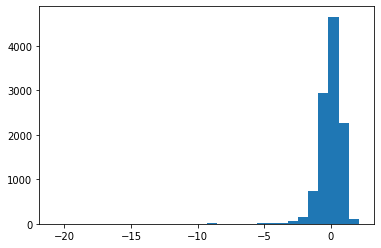

In [301]:
plt.figure()
plt.hist(birthmonth['BIRTHMONTH_Z_SCORE'], bins=30)
plt.show()

In [308]:
birthmonth[birthmonth['BIRTHMONTH_Z_SCORE']<=-5].shape[0]/birthmonth.shape[0]

0.0033599709407918636

In [309]:
final.columns

Index(['CHURN', 'ACC_ACTIVE_DAYS', 'DAY_SINCE_LAST_ACTIVE',
       'AVG_INTERVAL_BTW_LAST3', 'INTERVAL_CHG_LAST3', 'CHG_AVG_INTERVAL',
       'LAST_#_SESSIONS', 'CHG_AVG_#_SESSIONS', 'LAST_AVG_SESSION_LENGTH',
       'CHG_AVG_SESSION_LENGTH', 'LAST_AVG_COMPLETION_RATE',
       'CHG_AVG_COMPLETION_RATE', 'LAST_AVG_PASS_RATE', 'CHG_AVG_PASS_RATE',
       'LAST_AVG_STARS', 'CHG_AVG_STARS', 'LAST_AVG_POINTS', 'CHG_AVG_POINTS',
       'LAST_MOST_DIFFICULTY%', 'CHG_MOST_DIFFICULTY%', 'LAST_MOST_GAMETYPE%',
       'CHG_MOST_GAMETYPE%', 'LAST_AVG_IDLE%', 'LAST_AVG_ROUNDS_STARTED',
       'LAST_AVG_FAILED_ROUNDS', 'LAST_AVG_SUBMITS', 'LAST_AVG_SUCCESS%',
       'LAST_MOST_DIFFICULTY', 'LAST_MOST_GAMETYPE', 'BIRTHMONTH_Z_SCORE'],
      dtype='object')

In [315]:
import seaborn as sns

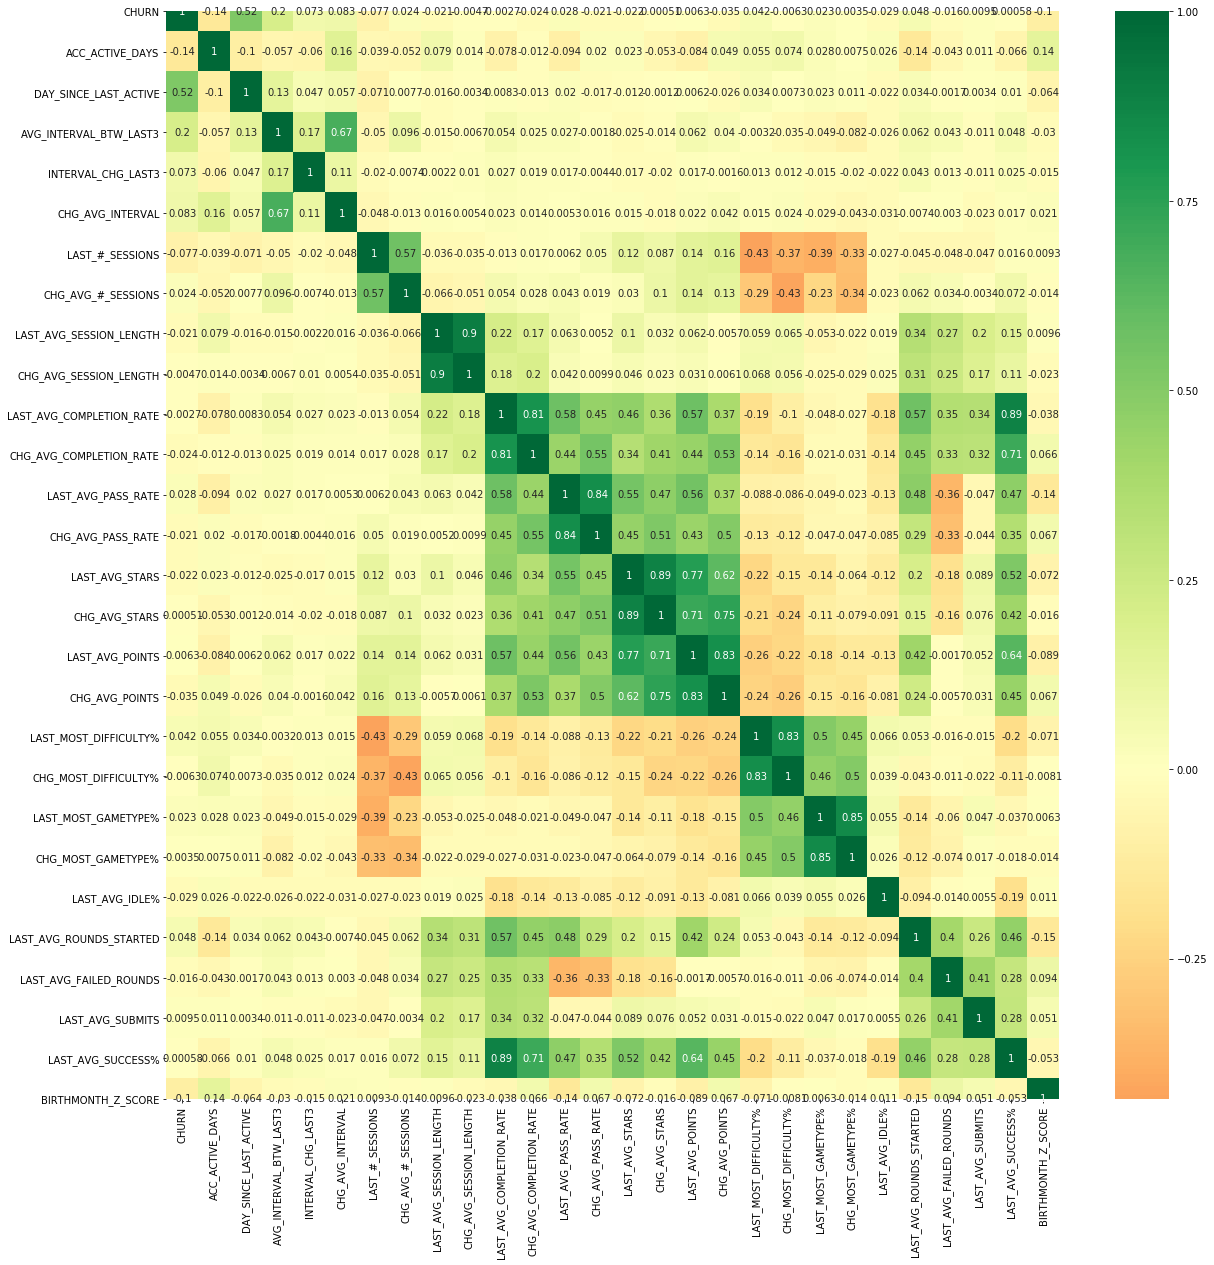

In [317]:
plt.figure(figsize=(20,20))
sns.heatmap(final.drop(['LAST_MOST_DIFFICULTY','LAST_MOST_GAMETYPE'], axis=1).corr(),
            cmap='RdYlGn',
            center = 0,
            annot=True)
plt.show()

<Figure size 432x288 with 0 Axes>

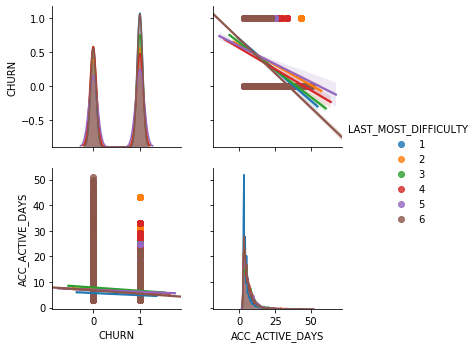

In [323]:
plt.figure()
sns.pairplot(final, kind='reg', hue='LAST_MOST_DIFFICULTY',
            x_vars = final.columns[0:2],
            y_vars = final.columns[0:2])
plt.show()

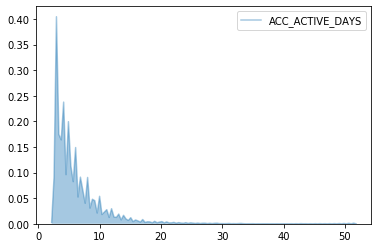

In [327]:
plt.figure()
sns.kdeplot(final['ACC_ACTIVE_DAYS'], shade=True, alpha=0.4)
plt.show()

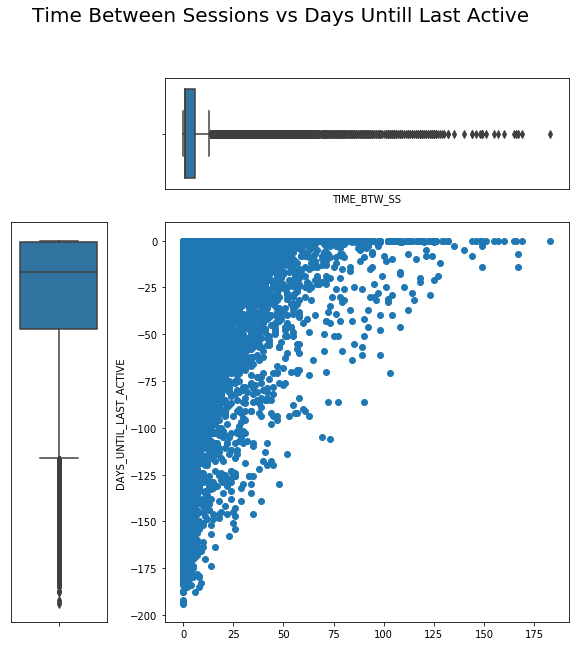

In [418]:
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(4,4,wspace = 0.6, hspace = 0.3)
ax_main = fig.add_subplot(grid[1:,1:])
ax_left = fig.add_subplot(grid[1:, 0], xticklabels = [], yticklabels = [])
ax_top = fig.add_subplot(grid[0, 1:], xticklabels = [], yticklabels = [])
ax_main.scatter('TIME_BTW_SS', 'DAY_TO_QUIT', data=history)
sns.boxplot(history['TIME_BTW_SS'], ax=ax_top)
sns.boxplot(history['DAY_TO_QUIT'], ax=ax_left, orient='v')
ax_main.set(ylabel='DAYS_UNTIL_LAST_ACTIVE')
ax_left.set_ylabel('')
ax_left.set(yticks=[])
ax_top.set(xticks=[])
#ax_left.axis('off')
fig.suptitle('Time Between Sessions vs Days Untill Last Active', fontsize=20)
plt.show()

In [391]:
history

,MEMBER_ID,ACTIVE_DATE,#_SESSIONS,TIME_BTW_SS,DAY,LIFETIME,DAY_TO_QUIT
0,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-20,8,0,1,3,-2
1,00061a613eab2b162e0e25fb59870260ec07cd06,2017-07-22,2,2,3,3,0
2,0012b722266d475b27e4e5e3946cb3d28305f7df,2017-07-25,4,0,1,1,0
3,0022e0f85f915460168cb98ab552f60cec91450d,2017-05-16,4,0,1,1,0
4,00236e6718e23a61a6ae7c7e7bb3244dc4dcb101,2017-07-02,19,0,1,1,0
5,002576a985c4614e1e7d918d4985b331d3093d34,2017-04-28,10,0,1,93,-92
6,002576a985c4614e1e7d918d4985b331d3093d34,2017-04-29,5,1,2,93,-91
7,002576a985c4614e1e7d918d4985b331d3093d34,2017-04-30,3,1,3,93,-90
8,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-14,5,14,17,93,-76
9,002576a985c4614e1e7d918d4985b331d3093d34,2017-05-18,2,4,21,93,-72
